<a href="https://colab.research.google.com/github/dgudy91/2021_AAPP_ML_workshop/blob/main/AAPP_ML_workshop_SOM_tutorial_data_subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INTRO**

This notebook steps through how to pre-process data, run the self-organising map algorithm and evaluate the output using atmospheric data from reanalysis models. 

In this session we will go through the basic considerations and data preparations required for running a SOM, using daily weather maps as the example input.  


---
***Background info***

*What is a Self Organising Map?*

A self-organising map (SOM) is a type of artificial neural network that is trained using unsupervised learning to produce a reduced dimensional, discretised representation of the input dataset.  In climate science, SOMs are often used to identify key regional weather patterns (e.g. High pressure/Low pressure systems) in an area of interest (without having to manually look at each daily weather map)

*Why use a Self Organising Map?*

The key purpose for using a SOM is to simplify the data by finding patterns.  When grouping/classifying weather types a key assumption is that daily weather patterns can be split into a specified number of "types". For this reason the SOM algorithm is often preferred for classifying weather over traditional discrete clustering methods (e.g. k-means). SOMs are able to account for continuity and nonlinearity (Jiang et al. 2012) more than clustering which provides a more realistic representation of the continuous movement of weather patterns.  

*What package is the best to use?*

The 'Kohonen' R package is very popular in climate science.  The documentation is available here: https://cran.r-project.org/web/packages/kohonen/kohonen.pdf

Side note: I bashed my head against the wall trying to get SOMs to work in python for 3+ months (using pySOM, miniSOM, SOMPY) but I couldn't get the packages to produce stable results. So I taught myself R to run SOMs (apologies in advance for messy coding)

---
ACKNOWLEDGMENTS

Thanks to Peter Gibson for providing the initial SOM code in R to get me started.  You can find his paper on using SOMs for studying climate extremes here: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD026256

Also thanks to Marc Mallet for helping me improve the structure and flow of the code. 


In [ ]:
## Set up access to GoogleDrive to download data for tutorial

#Step 1: Initialise
#install the Httpuv library - it allows R code to interact with HTTP and Websocket clients
install.packages("googledrive")
install.packages("httpuv")
library("googledrive")
library("httpuv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘promises’, ‘later’




In [ ]:
#Change local path - this can change with updates so might become out of date 
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { #may update python version  
                                       #occasionally
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




**DATA PRE-PROCESSING**

Prior to loading into R the following steps are generally required (depending on your research questions): 

1. Download reanalysis data/variables of interest (e.g. ECWMF: https://apps.ecmwf.int/datasets/, or stored on NCI if you have access)
2. Calculate daily anomalies to remove seasonality influence on the SOM output.  The seasonal signal will dominate the variability detected by the SOM algorithm so unless you are interested in seasonality remove prior to running the SOM. I used the Climate Data Operators tools to calculate (https://code.mpimet.mpg.de/projects/cdo/) 

FYI: Some useful cdo functions for processing netcdf data prior to loading into R

 - to merge multiple netcdf files together over time: 
 
 cdo -b F64 mergetime infiles*.nc mergetime_file.nc 

 - to select a region (e.g SH): 

 cdo -sellonlatbox,0,360,-90,0 mergetime_file.nc mergetime_regional_file.nc

- to calculate daily anomalies: 
 - a) convert 6hr dataset to daily using cdo daymean
 - b) create a file of daily climatology using cdo ydaymean
 - c) calculate the daily anomaly using cdo ydaysub infile1.nc climatologyfile.nc outfile.nc

  e.g. cdo -r -f nc4 -b 64 ydaysub z_500_dailymean_ERAI_historical_an-pl_1979-2018_SH.nc z_500_dailymeanstat_ERAI_historical_an-pl_1979-2018_SH.nc daily_anomaly_file.nc

**DATASET FOR THIS TUTORIAL**

1) Download dataset (64MB netcdf file) from the link provided in the workshop email. 

2) Create a folder in your google drive called ‘Datasets’

3) Move downloaded netcdf file to the ‘Datasets’ folder (z_500_dailyanomaly_ERAI_1979-1983_AAT.nc).  Note: You may need to upload the nc file from your local computer downloads folder to your google drive.

**Authenticate google drive** 

Copy and paste this line of code to the below cell and run (do not save these publically)


*drive_auth(use_oob = TRUE, cache = FALSE)*

Follow the promts to allow access between google colab and your google drive.  You should get a url link once authorised. Copy this into the blank box next to 'Enter authorization code:' 

**ALTERNATIVE DATA OPTION:** directly load the nc file to the google colab files using the 'upload to session storage' icon to the left. 

In [ ]:
#check working directory
getwd()

[1] "/content"

In [ ]:
#working directory is the content folder
#File information
f_name = "z_500_dailyanomaly_ERAI_1979-1983_AAT.nc"
ncfile_google = drive_get("~/Datasets/z_500_dailyanomaly_ERAI_1979-1983_AAT.nc")
drive_download(ncfile_google)

## OR IF YOUR GOOGLE DRIVE IS TOO FULL TO SAVE THE NETCDF YOU CAN UPLOAD THE FILE DIRECTLY UNDER THE FILES ICON TO THE LEFT





✔ The input `path` resolved to exactly 1 file.

File downloaded:

• z_500_dailyanomaly_ERAI_1979-1983_AAT.nc
  <id: 1aKOCDDkm-PKVBiHUcUQEcTWvmX6HUnPk>

Saved locally as:

• z_500_dailyanomaly_ERAI_1979-1983_AAT.nc



In [ ]:
#### Load library packages ####
library("tidyverse")
install.packages("tidync")
library("tidync") #A Tidy Approach to 'NetCDF' Data Exploration and Extraction
install.packages("kohonen")
library("kohonen") #SOM package
install.packages("viridis")
library("viridis") #Colorblind-Friendly Color Maps for R
install.packages("ggcorrplot") 
library("ggcorrplot") #Visualization of a correlation matrix using ggplot2
library("ggplot2") #plot results
install.packages("yardstick")
library("yardstick") #package to estimate how well models are working using tidy data principles

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’




Load the netcdf dataset using tidync into a table and check the data looks ok

In [ ]:
#Make netcdf connection, filter by time, read into tibble, create date column/
#ncfile = system.file("/content/z_500_dailyanomaly_ERAI_1979-1983_AAT.nc", package = "tidync")
z500_daily_subset <- tidync::tidync('/content/z_500_dailyanomaly_ERAI_1979-1983_AAT.nc') %>%
  hyper_filter(time = lubridate::as_datetime(time * 3600, origin = "1900-01-01 00:00:00") < 
                 lubridate::as_datetime("1983-12-31 23:00:00")) %>%
  hyper_tibble() %>%
  mutate(date = lubridate::as_datetime(time * 3600, origin = "1900-01-01 00:00:00")) %>%
  dplyr::select(-c(lev, time)) #get rid of unwanted columns

In [ ]:
#Check data is okay
head(z500_daily_subset)
summary(z500_daily_subset)

z,lon,lat,date
<dbl>,<dbl>,<dbl>,<dttm>
132.9492,40.50,-30,1979-01-01 09:00:00
146.1406,41.25,-30,1979-01-01 09:00:00
156.7031,42.00,-30,1979-01-01 09:00:00
164.8359,42.75,-30,1979-01-01 09:00:00
170.8086,43.50,-30,1979-01-01 09:00:00
173.8711,44.25,-30,1979-01-01 09:00:00


       z                  lon              lat        
 Min.   :-5120.441   Min.   : 40.50   Min.   :-75.00  
 1st Qu.: -712.066   1st Qu.: 74.06   1st Qu.:-63.75  
 Median :   17.711   Median :107.62   Median :-52.50  
 Mean   :   -0.572   Mean   :107.62   Mean   :-52.50  
 3rd Qu.:  701.141   3rd Qu.:141.19   3rd Qu.:-41.25  
 Max.   : 5447.410   Max.   :174.75   Max.   :-30.00  
      date                    
 Min.   :1979-01-01 09:00:00  
 1st Qu.:1980-04-01 09:00:00  
 Median :1981-07-01 21:00:00  
 Mean   :1981-07-01 21:00:00  
 3rd Qu.:1982-10-01 09:00:00  
 Max.   :1983-12-31 09:00:00  

The data variable (z) is currently geopotential pressure.  We can convert this to geopotential height by dividing by gravity.  

Geopotential height approximates the actual height of a pressure surface (e.g. 500hPa) above mean sea-level. 

In [ ]:
#convert geopotential pressure anomaly to geopotential height anomaly by dividing by gravity
#overwrite the z column with the calculated value
g = 9.80665
z500_daily_subset$z = z500_daily_subset$z/g
head(z500_daily_subset)
summary(z500_daily_subset)

z,lon,lat,date
<dbl>,<dbl>,<dbl>,<dttm>
13.55705,40.50,-30,1979-01-01 09:00:00
14.90220,41.25,-30,1979-01-01 09:00:00
15.97927,42.00,-30,1979-01-01 09:00:00
16.80859,42.75,-30,1979-01-01 09:00:00
17.41763,43.50,-30,1979-01-01 09:00:00
17.72992,44.25,-30,1979-01-01 09:00:00


       z                  lon              lat        
 Min.   :-522.1397   Min.   : 40.50   Min.   :-75.00  
 1st Qu.: -72.6106   1st Qu.: 74.06   1st Qu.:-63.75  
 Median :   1.8060   Median :107.62   Median :-52.50  
 Mean   :  -0.0583   Mean   :107.62   Mean   :-52.50  
 3rd Qu.:  71.4964   3rd Qu.:141.19   3rd Qu.:-41.25  
 Max.   : 555.4812   Max.   :174.75   Max.   :-30.00  
      date                    
 Min.   :1979-01-01 09:00:00  
 1st Qu.:1980-04-01 09:00:00  
 Median :1981-07-01 21:00:00  
 Mean   :1981-07-01 21:00:00  
 3rd Qu.:1982-10-01 09:00:00  
 Max.   :1983-12-31 09:00:00  

**Getting the dataset ready for the SOM algorithm**

1) we need to convert the dataset from a long format table to a wide format table

2) we need to remove the date column

In [ ]:
#Currently the dataset consists of 4 columns: z, lon, lat and time - this is called long form
#But the SOM algorithm input requires the dataset to have time as rows, and each combination of lat/lon as columns - this is called wide form

#To restructure the dataset we need to use the pivot function to transform the long form dataset into wide from. 

#Pivots data from long to wide format. 
#Each row is a date, each column is the geopotential at an individual coordinate
z500_daily_subset_wide <- z500_daily_subset %>%
  pivot_wider(., id_cols = date, names_from = c(lat, lon), values_from = `z`) 

In [ ]:
#lets check the data again
head(z500_daily_subset_wide)

date,-30_40.5,-30_41.25,-30_42,-30_42.75,-30_43.5,-30_44.25,-30_45,-30_45.75,-30_46.5,⋯,-75_168,-75_168.75,-75_169.5,-75_170.25,-75_171,-75_171.75,-75_172.5,-75_173.25,-75_174,-75_174.75
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1979-01-01 09:00:00,13.55705,14.902196,15.979272,16.808588,17.4176292,17.729917,17.819142,17.747045,17.543102,⋯,39.00813,39.91193,40.75399,41.58291,42.40625,43.25628,44.13061,45.05234,46.00513,46.99737
1979-01-02 09:00:00,-13.49093,-9.868543,-6.300333,-2.926506,0.1278629,2.870342,5.247954,7.165896,8.686707,⋯,104.58703,106.32812,108.04610,109.76448,111.50039,113.24705,114.99571,116.74595,118.46991,120.15165
1979-01-03 09:00:00,-96.68065,-86.290298,-76.236533,-67.079800,-58.9419871,-51.325583,-44.255684,-38.010320,-32.413831,⋯,126.13730,126.87819,127.56411,128.21059,128.82601,129.43704,130.07436,130.69296,131.31396,131.89711
1979-01-04 09:00:00,-223.33538,-229.759191,-231.858771,-229.082832,-220.9593586,-208.130054,-192.128874,-174.597722,-156.396983,⋯,94.62010,95.88957,97.09650,98.26280,99.39843,100.49901,101.57130,102.62209,103.61113,104.51733
1979-01-05 09:00:00,-123.48325,-134.126938,-144.024559,-152.800890,-160.4376080,-166.916391,-171.934112,-175.121123,-176.036478,⋯,38.56997,39.90954,41.31125,42.76315,44.26405,45.79920,47.36622,48.92806,50.48193,51.98681
1979-01-06 09:00:00,-86.73563,-87.363788,-88.064046,-88.921644,-89.9369784,-91.110449,-92.353626,-93.503595,-94.467944,⋯,-35.53313,-36.13898,-36.65840,-37.06907,-37.37021,-37.54547,-37.56818,-37.47736,-37.24872,-36.87071


In [ ]:
#We need to remove the date column for the actual som calculation
z500_daily_subset1d <- z500_daily_subset_wide %>%
  dplyr::select(-date)

**Now lets set up the parameters for the SOM algorithm**

1) Number of nodes and structure of grid
(e.g. 3 x 3 grid = 9 output nodes)

*The output results are most sensitive to this parameter*
*   As you reduce the number of output nodes the results are more generalised & become closer to the mean of the field.
*   As you increase the number of output nodes the results become more specific to the input data. 
*   Finding the balance of the number of nodes is subjective and depends on what type of features/questions you are trying to answer 

2) Number of iterations (rlen) 

*number of times the complete dataset will be presented to the network*

3) Neighbourhood Radius (rad)

*Number of surrounding nodes from the winning node activated each time the winning node is selected.  This parameter is a key difference between k-means and SOM clustering*

*This parameter is generally set to start high (e.g. 4) and reduce to either 1 (100% SOM for all iterations) or 0 (75% of iterations SOM & 25% discrete clustering).  In the R Kohonen package, a radius value below 1 = no surrounding nodes activated = k-means clustering*

4) Learning rate (alp)

*Magnitude that each winning node is influenced by the input data.  For the first few iterations this is set to be a fast learning rate and reduces to a slower learning rate near the end of the interations to improve accuracy*


In [ ]:
#### SET UP SOM PARAMETERS ####

#SOM sequential mode: training is goverened by: 
# 1. learning rate parameter (alpha)
# 2. neighbourhood radius (radius)
# 3. number of iterations (rlen)

#default parameters:
#rlen = 100
#alp = c(0.05,0.01)
#rad = c(5,1)

#Number of Nodes and structure of grid
#e.g. 9 nodes with a 3x3 grid
Nnodes = 9
nx = 3
ny = 3

# number of iterations - rlen
rlen = 100             # number of times the complete dataset will be presented to the network
#rlen -> use 100 for initial testing/demo -> increase to 1000+ when actually running

# learning rate parameter - alpha
alp = c(0.05,0.01)     # learning rate -> magnitude each node pattern is updated 
# Requires vector of two numbers indicating the amount of change
# Default (decrease from 0.05 to 0.01 linearly over rlen updates)

# neighbourhood radius - radius
rad = c(4,0)             # Number of surrounding nodes activated - # 75% SOM, 25% clustering.
# value < 1 no surrounding nodes activated = k-means clustering
#100% SOM example: rad = c(4,1)

#grid structure of SOM ("rect", "hexagonal)
gr = "rect"  #update manually in SOM algorithm.  This is for filename setup. 

#data type - "raw","detrended","daily_anomaly"
dt = "daily_anomaly"  #this is for filename setup


#NOTE: this code is using the single - sequential method.  
#Can also run in batch - refer to the documentation

**LETS RUN A SOM**

In [ ]:
### RUNNING THE SOM & SAVING VARIABLES
set.seed(5) #this is important for consistent results between runs

#input data 
data = z500_daily_subset1d

#Play around with number of nodes
Nnodes = 12
nx = 3
ny = 4

#SOM algorithm
print("running SOM algorithm.......")
K_SOM = som(X = data.matrix(data),
            grid = somgrid(nx,ny,"rect","gaussian"),
            rlen = rlen,
            alpha = alp,
            radius = rad,
            keep.data = T,
            dist.fcts = c("euclidean"),
            normalizeDataLayers = FALSE)

print("finished running SOM")


[1] "running SOM algorithm......."
[1] "finished running SOM"


Save variables

In [ ]:
#Save variables
K_SOM_d    <- data.frame(K_SOM$distances)        # get errors -> distances between grids
K_SOM_SOM  <- data.frame(K_SOM$codes)            # get clusters grid
tmp        <- data.frame(t(K_SOM_SOM))           # transpose
K_SOM_SOMc <- data.frame(unlist(tmp))           # concatenate codebook vectors to 1 row
K_SOM_win  <- data.frame(K_SOM$unit.classif)     # get clusters win
K_SOM_grid <- data.frame(K_SOM$grid[["pts"]])    # get grid structure

#column binds two vectors - one of the individual dates and one of the winning nodes
winning_nodes <- cbind(z500_daily_subset_wide$date,K_SOM_win)      #finds the winning nodes of each timestep - daily data      
colnames(winning_nodes) <- c("date","node") 


Attach the winning node information to the original dataset and calculate the composite pattern for each output node

In [ ]:
#This attaches the winning nodes data to the original data subset, matching by "date"
z500_daily_subset_winning_nodes <- dplyr::left_join(z500_daily_subset, winning_nodes, by = "date")

In [ ]:
#This calculates the SOM composite for each node, for each coordinate
som_means <- z500_daily_subset_winning_nodes %>%
  group_by(lat, lon, node) %>%
  summarise(som_z500_mean = mean(`z`, na.rm = TRUE))

`summarise()` has grouped output by 'lat', 'lon'. You can override using the `.groups` argument.



**Plot the SOM composite maps**

Regions defined for each Polygons



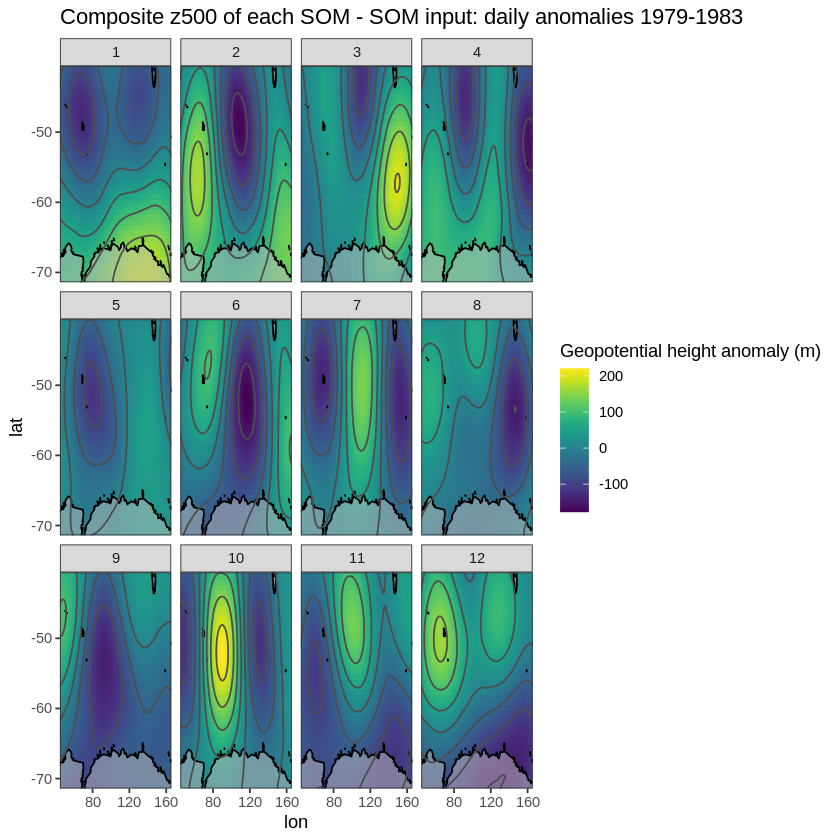

In [ ]:
install.packages("maptools")
library(maptools)
data(wrld_simpl)

#Plot the SOM composites with coastlines. 
ggplot() + 
  geom_tile(data = som_means, aes(x = lon, y = lat, fill = som_z500_mean)) + 
  scale_fill_viridis() +
  facet_wrap(~node) +
  theme_bw() +
  geom_polygon(data=wrld_simpl, 
               aes(x=long, y=lat, group=group), fill='grey', colour = 'black', alpha = 0.5)  +
  coord_cartesian(xlim=c(50,160), ylim=c(-70,-42)) +
  geom_contour(data = som_means, aes(x = lon, y = lat, z = som_z500_mean), colour = "grey30") +
  labs(title = "Composite z500 of each SOM - SOM input: daily anomalies 1979-1983",
       fill = "Geopotential height anomaly (m)")


**Evaluate the SOM performance for capturing 'real world' weather patterns**

Method: Pearson pattern correlation between the composite winning node pattern and each daily input assigned to the winning node.  

Refer to Gibson et al. 2017 ( https://doi.org/10.1002/2016JD026256); Udy et al. 2021 (https://doi.org/10.1175/JCLI-D-20-0297.1) for more details. 

In [ ]:
#calculate pearson pattern correlation between the composite winning node pattern and each daily input assigned to the winning node
# refer to Gibson et al. 2017; Udy et al. 2021 (https://doi.org/10.1175/JCLI-D-20-0297.1) for more details


nodes <- seq(from = 1, to = Nnodes, by = 1)

calculate_som_temporal_correlation <- function(nodes){
  
  som_temporal_correlation <- left_join(z500_daily_subset_winning_nodes %>%
                                                filter(node == nodes), 
                                              som_means %>% filter(node == nodes)) %>%
    group_by(date) %>%
    yardstick::rsq(., `z`, som_z500_mean) %>%
    mutate(node = nodes)
  
  som_temporal_correlation
  
}


Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")

Joining, by = c("lon", "lat", "node")



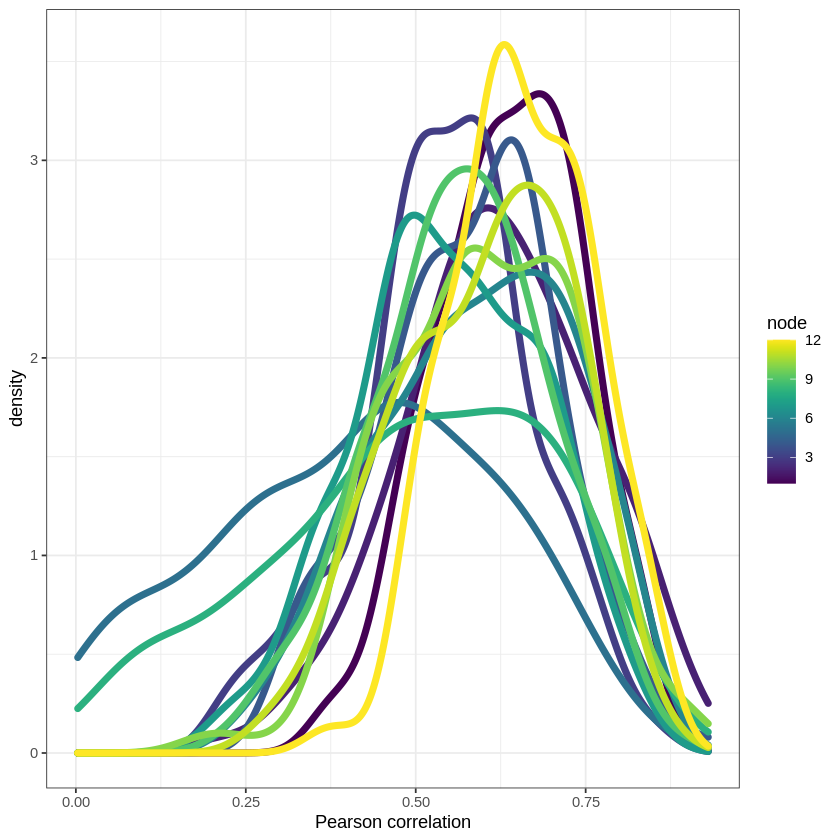

In [ ]:
### PLOT THE CORRELATION SCORES FOR EACH SOM NODE
#as the number of nodes increase, the correlation scores should improve
#as the number of nodes decrease, the correlation scores will likely go down. 
#Determining the right number of nodes is subjective, but you can be guided by how many patterns you roughly
#expect to find (i.e. stare at weather maps alot), and how sensitive the results

som_temporal_correlations <- purrr::map_dfr(nodes, calculate_som_temporal_correlation)

ggplot(data = som_temporal_correlations, aes((.estimate ^ 0.5), colour = node, group = node)) +
  geom_density(size = 2) +
  scale_color_viridis() +
  #facet_wrap(~node) + #uncomment this line to plot them as separate facets
  theme_bw() +
  labs(x = "Pearson correlation")

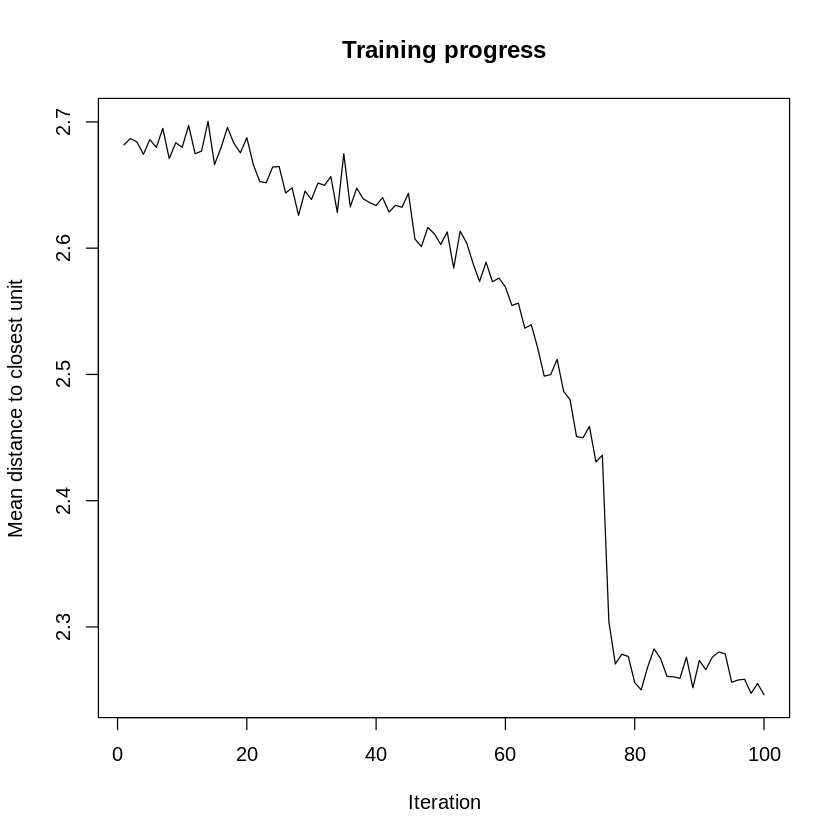

In [ ]:
### SOME OTHER THINGS TO CHECK: 
#Check the training progress (unlikely to reach optimal level with only 100 iterations)
#changes - training process -> mean distance to closest unit
#png(paste("SOM_training_",filename_end, sep=""), width = 888, height = 428)
plot(K_SOM, type="changes")
#dev.off()

In [ ]:
#SET UP FILENAMES FOR OUTPUT FILES/PLOTS
rundate = '2021-08-30' #update for each run
run_num = 'testrun_01' #update for each run
seas = 'daily_z500_anomaly'

#set output directory
#google colab
setwd('/content') #update when running locally

filename_end = paste("n",Nnodes,"_",dt,"_rlen",rlen,"_alp",alp[1],"to",alp[2],"_rad",rad[1],"to",rad[2],".png", sep="")  
#sep removes spaces in filename
print(filename_end)

#write txt file with parameters for run - save in subfolder
sink(paste0(run_num,"_Parameters.txt"))
cat(paste0("Run Date ",rundate))
cat("\n")
cat(paste0("Parameters: data = ",dt,",dist.fcts = euclidean, grid = ",gr,"Nodes = ",Nnodes, "rlen = ",rlen,", alp",alp[1],"to ",alp[2],", rad",rad[1],"to ",rad[2]))
sink()

[1] "n9_daily_anomaly_rlen100_alp0.05to0.01_rad4to0.png"
Run Date 2021-08-30
Parameters: data = daily_anomaly,dist.fcts = euclidean, grid = rectNodes = 9rlen = 100, alp0.05to 0.01, rad4to 0

In [ ]:
### SAVE TXT FILE OF WINNING NODES
write.table(winning_nodes, file=paste("SOM_tutorial_test_",seas,"_",nx,"_",ny,".txt", sep=""),row.names=F, col.names=T, quote=F)
print("file written as ....", quote=F)
print(paste("SOM_tutorial_test_",seas,"_",nx,"_",ny,".txt", sep=""))


[1] file written as ....
[1] "SOM_tutorial_test_daily_z500_anomaly_3_3.txt"


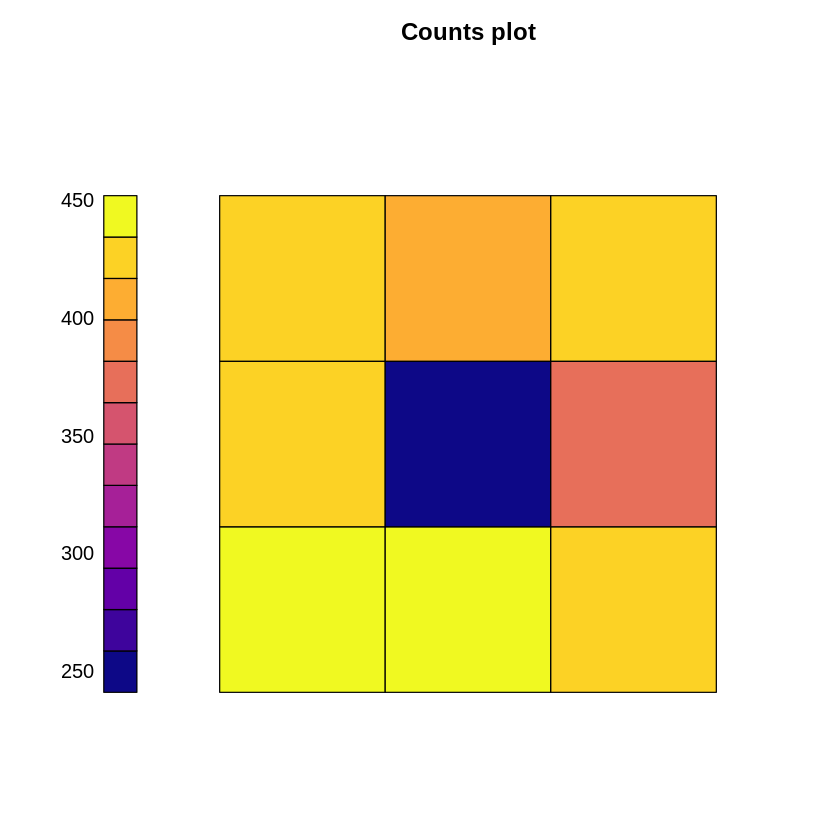

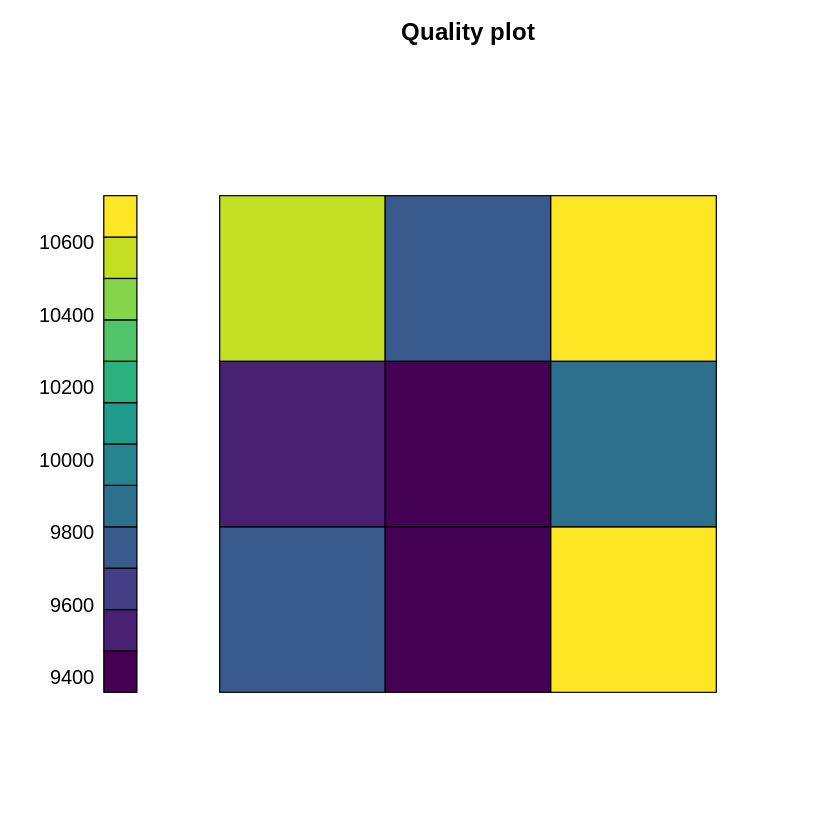

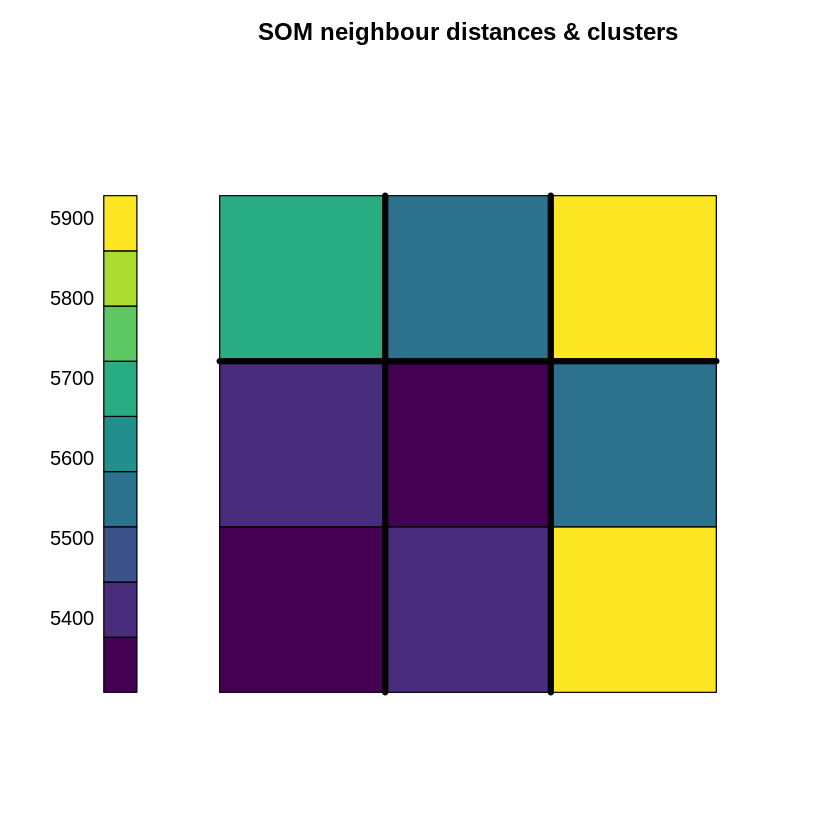

In [ ]:
###OTHER PLOTS AVAILABLE IN KOHONEN PACKAGE

#### quality & count ####
#quality - shows the mean distance mapped to a unit to the codebook vector of that unit. 
# smaller distances = objects (e.g daily z500) represented better by the codebook vectors. 
# counts - number of objects mapped to SOM nodes - frequency?

counts <- plot(K_SOM, type = "counts", 
               palette = plasma, ncolors = 12, 
               shape = "straight")
quality <- plot(K_SOM, type = "quality", 
                palette = viridis, ncolors = 12,
                shape = "straight")

#U matrix/distance neighbours & hierachial clustering
plot(K_SOM,type = "dist.neighbours", 
     main = "SOM neighbour distances & clusters",
     palette = viridis,
     shape = "straight")
#hierarchial clustering to cluster the codebook vectors
som.hc <- cutree(hclust(object.distances(K_SOM,"codes")),6)  #random no. of clusters selected
add.cluster.boundaries(K_SOM, som.hc)